# Maxima finder

Jack Dinsmore, July 2020

In this notebook, I actually look at where the stellar maxima are. They do not corellate with star position. In fact, they seem to slightly anti-corellate with star position. This makes the maxima method hard to justify, although it works well in practice.

At the end, I realize that the radial density of maxima as a function of radius fits an exponential function, and therefore we may be able to count maxima as a metric for cluster density. But this may not be useful.

In [94]:
%matplotlib inline
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math

#CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
CLUSTERS = ["NGC 6231"]
CLUSTERS = ["M34", "M7", "NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Collinder 140", "Omega Cen", "47 Tuc"]
CLUSTERS = ["NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
NUMBER_PCA_COMPONENTS = 10

SCALE_FACTOR = 1.5
LOWER_LIMIT = 10
IMAGE_SIZE = 180
MIN_RADIUS = 8

In [95]:
def getMaximaMask(data):
    stars = 0
    mask = np.zeros_like(data)
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                mask[x][y] = 1
    return mask

In [99]:
def getPredictedDensity(x, parameter, mn, mx):
    return (mx - mn) * (1 - math.exp(-parameter * (x-MIN_RADIUS))) + mn

In [105]:
tpfs = [0]*len(CLUSTERS)

class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)
        
        #self.image = self.tpf[self.tpf.flux.shape[0] // 2].flux.reshape((180, 180))
        self.image = np.mean(self.tpf.flux, axis=0)
        self.exp = None
        self.mask = None
        
            
    def displayMaxima(self):
        self.mask = getMaximaMask(self.image)
        
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
        a = ax1.imshow(self.image, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title(self.name + " TPF")
        plt.colorbar(a, ax=ax1)
        
        b = ax2.imshow(self.mask)
        ax2.set_title(self.name + " maxima")
        plt.colorbar(b, ax=ax2)
        
        image = self.image[:]
        for x in range(self.mask.shape[0]):
            for y in range(self.mask.shape[1]):
                if self.mask[x][y] == 1:
                    image[x][y] =0
        c = ax3.imshow(self.image, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax3.set_title(self.name + " TPF")
        plt.colorbar(c, ax=ax3)
        
    def getRadialDensity(self):
        self.radii = []
        self.densities = []
        for r in range(MIN_RADIUS, IMAGE_SIZE // 2):
            count = 0
            for x in range(IMAGE_SIZE // 2 - r, IMAGE_SIZE // 2 + r):
                for y in range(IMAGE_SIZE // 2 - r, IMAGE_SIZE // 2 + r):
                    count += self.mask[x][y]
            self.radii.append(r)
            self.densities.append(count / (3.1415926535 * r * r))
            
        self.max = self.densities[-1]
        self.min = min(self.densities)
            
    def getLeastSquares(self, parameter):
        s = 0
        for i in range(len(self.radii)):
            s += (getPredictedDensity(self.radii[i], parameter, self.min, self.max) - self.densities[i])**2
        return s
            
    def getExp(self):
        PRECISION = 0.001
        sumMin = self.getLeastSquares(0)
        parameterMin = 0
        i = PRECISION
        
        while i < 0.1:
            sumNow = self.getLeastSquares(i)
            if(sumNow < sumMin):
                sumMin = sumNow
                parameterMin = i
            i+= PRECISION
        self.parameter = parameterMin
        self.exp = [getPredictedDensity(r, self.parameter, self.min, self.max) for r in self.radii]
    
    def displayRadialDensity(self):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,2.2]})
        
        image = self.image[:]
        for x in range(self.mask.shape[0]):
            for y in range(self.mask.shape[1]):
                if self.mask[x][y] == 1:
                    image[x][y] =0
        c = ax1.imshow(self.image, vmin=0, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title(self.name + " TPF")
        plt.colorbar(c, ax=ax1)
        
        ax2.plot(self.radii, self.densities)
        ax2.set_title(self.name + " radial maxima density distribution")
        ax2.set_xlabel("Radius (pixels)")
        ax2.set_ylabel("Density (maxima / square pixel)")
        if(self.exp != None):
            ax2.plot(self.radii, self.exp)
            ax2.legend(["Observed density", "Fitted density"])

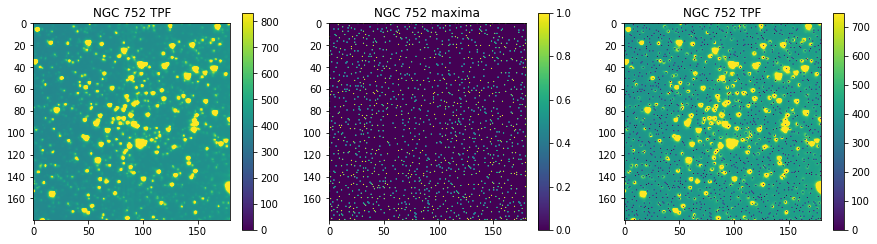

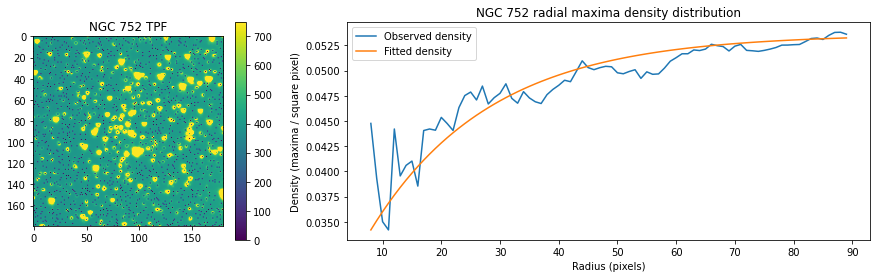

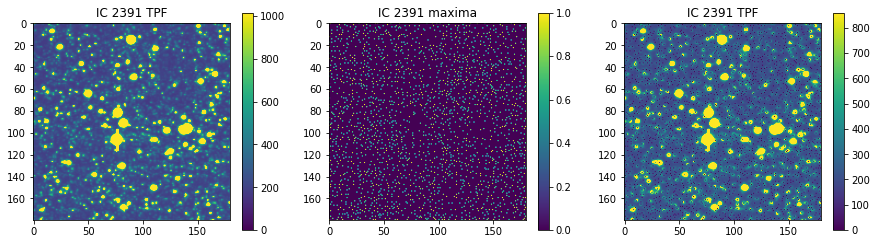

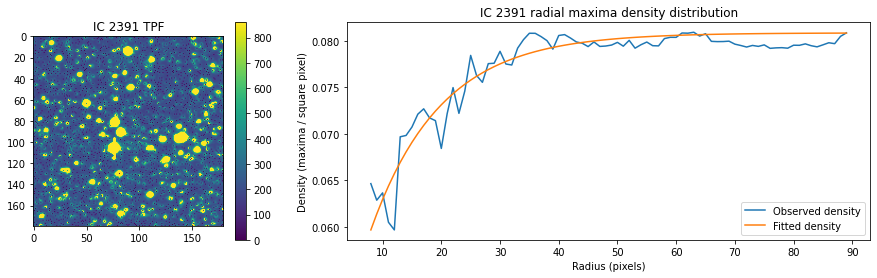

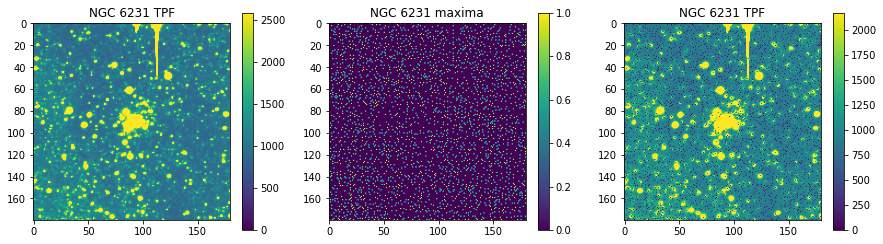

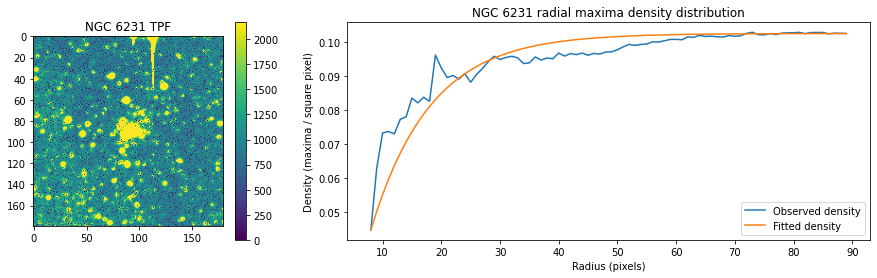

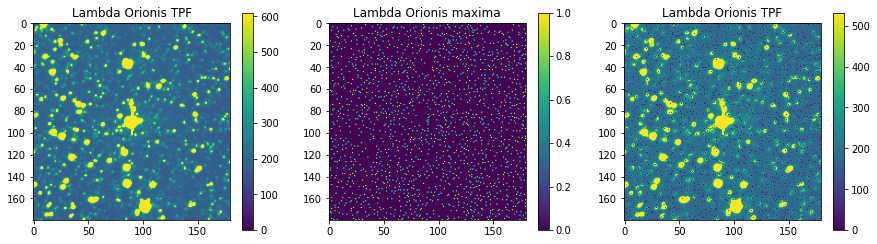

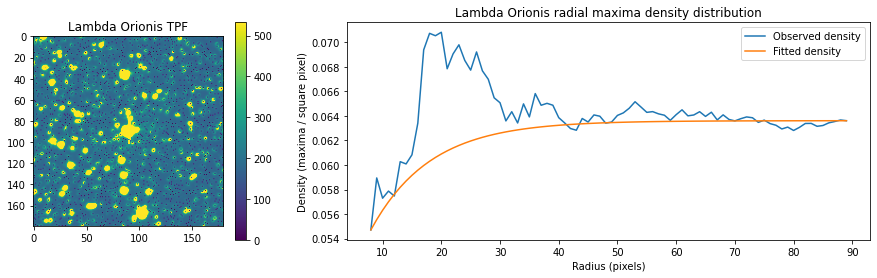

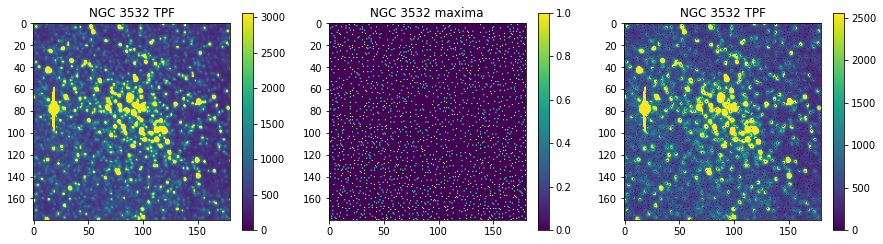

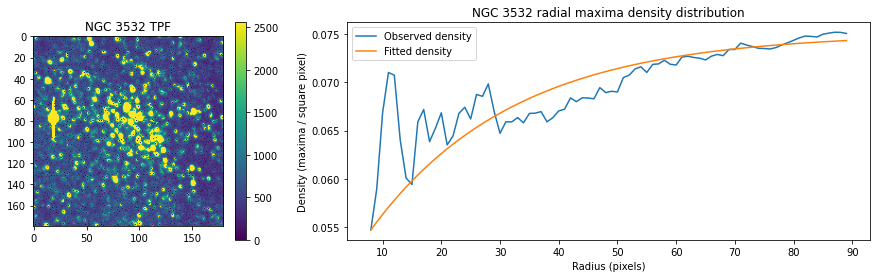

In [106]:
for c in CLUSTERS:
    cl = Cluster(c)
    #cl.displayTPF()
    cl.displayMaxima()
    cl.getRadialDensity()
    cl.getExp()
    cl.displayRadialDensity()